In [1]:
import numpy as np
import pandas as pd
import math
from itertools import count
from tqdm.auto import tqdm
import threading
import os, platform
import multiprocessing
import subprocess
from queue import Empty as QueueEmpty
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from matplotlib import rc
rc('text',usetex=True)
rc('text.latex', preamble='\\usepackage{color}')

In [25]:
# model_list_name, output_dir = 'models_random_5_15_s5', 'results_random_5_15_s5'
# model_list_name, output_dir = 'models_random_6_20_s5', 'results_random_6_20_s5'
model_list_name, output_dir = 'models_random_6_15', 'results_random_6_15' # *****
# model_list_name, output_dir = 'models_random_5_12', 'results_random_5_12'
# model_list_name, output_dir = 'models_mcc200', 'results_mcc200'
# model_list_name, output_dir = 'models_mcc2', 'results_mcc2' # *****
# model_list_name, output_dir = 'models_mcc200quick', 'results_mcc200quick'
# model_list_name, output_dir = 'models_random', 'results_random'
max_time = 5 # 5
n_parallel = 4 # 8
run_all = False # run all tests or only those that don't have the .log file

In [26]:
# Load models and benchmark definition
model_list = open(model_list_name+'.txt', 'r').readlines()
model_list = [ f.replace('\n', '') for f in model_list ]
model_list = [ f for f in model_list if len(f) > 0 ]
# model_list = model_list[:10]
print(len(model_list))
os.makedirs(output_dir, exist_ok=True)

100


In [27]:
def run_commands(queue, pin, pbar):
    while True:
        try:
            qe = queue.get()#block=False)
            if qe is None:
                break
            # print(qe)
            tool, test_name, args, model_fname = qe
            model_basename = model_fname.split('/')[-1]
            logfile = f'{output_dir}/{model_basename}-{test_name}.log'
            os.remove(logfile) if os.path.exists(logfile) else None
            if run_all or not os.path.exists(logfile):
                # print(logfile)
                with open(logfile, 'w') as f:
                    print('****************', file=f)
                    print(f'MODEL={model_fname}\n', file=f)
                    f.flush()
                    if platform.system()=='Darwin':
                        cmd = f'gtimeout {max_time}s '
                    else:
                        cmd = f'/usr/bin/time --verbose /usr/bin/timeout {max_time}s taskset -c {2*pin} ' 
                    # cmd = ''
                    if tool=='sym':
                        cmd += f'../build/sym_hilbert -c -p -u {model_fname} {args} '
                    elif tool=='4ti2':
                        cmd += f'{args} {model_fname} '
                
                    try:
                        proc = subprocess.run(cmd, shell=True, stdout=f, stderr=f)
                        exitcode = proc.returncode
                    except subprocess.TimeoutExpired:
                        exitcode = 124  # timeout

                # append exit status to the log file
                with open(logfile, 'a') as f:
                    print(f'\nEXITCODE={exitcode}\n', file=f)

                if exitcode not in [0,124]:
                    print(qe, f'EXITCODE={exitcode}')
            pbar.update(1)
        except QueueEmpty:
            print('queue empty')
            break # no more commands
    # print(f'Thread {pin} ends.')

In [28]:
tests = [
    # # [ "sym",  'TestKerA',    '' ],
    # ######### Hilbert basis #########
    # [ "4ti2", "Hil_4ti2",  "/home/elvio/4ti2/src/zsolve/hilbert" ],
    # [ "sym",  'Hil_Ga',    '-ye -nl' ],
    # [ "sym",  'Hil_GL',    '-ye -yl' ],
    # [ "sym",  'Hil_na',    '-ne -nl' ],
    # [ "sym",  'Hil_nL',    '-ne -yl' ],
    # [ "sym",  'Hil_nLH',    '-ne -yl -hg' ],
    # [ "sym",  'Hil_LD',    '-ne -yl -yd' ],
    # # [ "sym",  'Hil_nP',    '-ne -yl -po' ],
    # [ "sym",  'Hil_LS',    '-ne -yl -s' ],
    # # [ "sym",  'Hil_LZ',    '-ne -yl -z' ],
    # # [ "sym",  'Hil_LZD',   '-ne -yl -z -yd' ],
    # # [ "sym",  'Hil_LZS',   '-ne -yl -z -yd -s' ],
    # [ "sym",  'Hil_HNF',   '-ne -yl -yd -np' ],
    # [ "sym",  'Hil_IGE',   '-ne -yl -yd -np -ige' ],

    # ######### Extreme Rays #########
    # # [ "4ti2", "Ray_4ti2",  "/home/elvio/4ti2/src/groebner/rays" ],
    # [ "sym",  'Ray_nL',    '-ne -yl -x' ],
    # # [ "sym",  'Ray_LZ',    '-ne -yl -z -x' ],
    # # [ "sym",  'Ray_LD',    '-ne -yl -d -x' ],
    # # [ "sym",  'Ray_LZD',   '-ne -yl -z -yd -x' ],
    # # [ "sym",  'Ray_LS',    '-ne -yl -s -x' ],
    # # # [ "sym",  'Ray_LZS',   '-ne -yl -z -s -x' ],
    # # # [ "sym",  'Ray_nP',    '-ne -yl -po -x' ],

    # ######### Graver basis #########
    [ "4ti2", "Gra_4ti2",  "/home/elvio/4ti2/src/zsolve/graver" ], 
    # [ "4ti2", "Gra_4ti2",  "time graver" ], # "/home/elvio/4ti2/src/zsolve/graver"
    # [ "sym",  'Gra_Ga',    '-ye -nl -g' ],
    [ "sym",  'Gra_pottier',   '-g -nl' ],
    [ "sym",  'Gra_PnL',       '-g -yl' ],
    # [ "sym",  'Gra_nG',    '-yeg -nl -g -po' ],
    [ "sym",  'Gra_degree',    '-g -s' ],
    # [ "sym",  'Gra_nLH',    '-ne -yl -g -hg' ],
    # # # [ "sym",  'Gra_nP',    '-ne -yl -po -g' ],



    # [ "sym",  'Gra_degree',    '-g -s -ps' ],
    # [ "sym",  'Ray_degree',    '-x -s -ps' ], # deactivated
    # [ "sym",  'Hil_degree',    '   -s -ps' ],

    # [ "sym",  'Hil_pottier',    '-nl' ],
    # [ "sym",  'Hil_PnL',    '-yl' ],

    # [ "sym",  'Ray_pottier',   '-x -nl' ],
    # [ "sym",  'Ray_PnL',       '-x -yl' ],
    # [ "sym",  'Ray_degree',    '-x -yl -s' ],
]
# generate commands
queue = multiprocessing.Queue(maxsize=10000)
num_runs = 0
for tool, test_name, args in tests:
    for model in model_list:
        queue.put([tool,  test_name, args, model])
        num_runs += 1
print('num_runs=',num_runs)
for i in range(n_parallel):
    queue.put(None)

num_runs= 400


In [29]:
# with tqdm(total=num_runs) as pbar:
#     # run the commands in parallel
#     threads = []
#     for i in range(n_parallel):
#         threads.append(threading.Thread(target=run_commands, args=(queue, i, pbar)))
        
#     for t in threads: # start all threads
#         t.start()
#     for t in threads: # wait for all terminations
#         t.join()
# queue.close()
# print('Done')

In [30]:
data = []
for model_fname in model_list:
    model_basename = model_fname.split('/')[-1]
    row = {'model':model_basename}
    row['mdd_nodes'] = row['mdd_edges'] = None
    for tool, test_name, args in tests:
        logfile = f'{output_dir}/{model_basename}-{test_name}.log'
        if os.path.exists(logfile):
            tm = None
            cntC = None
            with open(logfile) as f:
                for line in f:
                    line = line.strip()
                    if line.startswith('User time'):
                        tm = float(line.split(':')[1])
                    elif line.startswith('CPU usage'):
                        tm = float(line.split(':')[1])
                    elif 'user' in line and 'sys' in line:
                        tm = float(line.split()[2])
                    elif line.startswith('Total S-Vectors processed') or line.startswith('_completed_svectors:') or line.startswith('Added:'):
                        # print(line, float(line.split(':')[1]))
                        cntC = int(float(line.split(':')[1]))
                    elif line.startswith('EXITCODE'):
                        # ec = int(re.sub(' +', ' ', line).split(' ')[1])
                        ec = int(line.split('=')[1])
                        if ec==124:
                            tm = None
                        elif ec != 0:
                            print(line, logfile)
                    elif line.startswith('Z-Generators:'):
                        row['num_Zgens'] = int(line.split(':')[1])
                    # elif line.startswith('Final basis has'):
                    #     row['out_sz'] = float(line.split(' ')[5] // 2)
                    elif line.startswith('Basis:') or line.startswith('out_sz:'):
                        row['out_sz'] = float(line.split(':')[1])
                    elif line.startswith('Variables:'):
                        row['num_vars'] = int(line.split(':')[1])
                    elif line.startswith('Basis MDD Nodes:'):
                        row['mdd_nodes'] = int(line.split(':')[1])
                    elif line.startswith('Basis MDD Edges:'):
                        row['mdd_edges'] = int(line.split(':')[1])
                    
                    if line.startswith('_completes:'):
                        row['4ti2_completes'] = int(line.split(':')[1])
                    elif line.startswith('_builds:'):
                        row['4ti2_builds'] = int(line.split(':')[1])
                    elif line.startswith('_reductions:'):
                        row['4ti2_reductions'] = int(line.split(':')[1])
                    elif line.startswith('_insertions:'):
                        row['4ti2_insertions'] = int(line.split(':')[1])
                    elif line.startswith('_completed_svectors:'):
                        row['4ti2_completed_svectors'] = int(line.split(':')[1])
            row[test_name] = tm
            row[test_name+'_C'] = cntC
    data.append(row)
data = pd.DataFrame(data)
data.to_csv(f'data_{model_list_name}.csv', index=False)
print(f'data_{model_list_name}.csv')

data_models_random_6_15.csv


In [31]:
data.head(10)

,model,mdd_nodes,mdd_edges,4ti2_completes,4ti2_builds,4ti2_reductions,4ti2_insertions,4ti2_completed_svectors,out_sz,Gra_4ti2,Gra_4ti2_C,num_Zgens,num_vars,Gra_pottier,Gra_pottier_C,Gra_PnL,Gra_PnL_C,Gra_degree,Gra_degree_C
0,problem000,2170.0,3322.0,7358.0,624632.0,27995.0,1379.0,29374.0,1388.0,0.14,29374.0,9,15,4.21,219938.0,0.68,15643.0,1.03,31020.0
1,problem001,93.0,153.0,255.0,5011.0,194.0,196.0,390.0,206.0,0.01,390.0,10,15,0.02,6149.0,0.01,1936.0,0.01,2309.0
2,problem002,63.0,91.0,368.0,520.0,31.0,21.0,52.0,30.0,0.00,52.0,9,15,0.00,204.0,0.00,43.0,0.01,47.0
3,problem003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,15,NaN,NaN,NaN,NaN,NaN,NaN
4,problem004,242.0,381.0,440.0,16204.0,3352.0,252.0,3604.0,261.0,0.01,3604.0,9,15,0.08,15071.0,0.02,1376.0,0.03,1907.0
5,problem005,108.0,149.0,118.0,879.0,84.0,33.0,117.0,42.0,0.00,117.0,9,15,0.01,501.0,0.00,83.0,0.01,84.0
6,problem006,392.0,580.0,480.0,39781.0,5326.0,366.0,5692.0,375.0,0.01,5692.0,9,15,0.17,29834.0,0.03,2955.0,0.08,3690.0
7,problem007,482.0,781.0,3378.0,862481.0,5111.0,1367.0,6478.0,1376.0,0.06,6478.0,9,15,0.76,205537.0,0.16,9637.0,0.34,11067.0
8,problem008,1218.0,1545.0,6284.0,72405.0,6673.0,319.0,6992.0,328.0,0.03,6992.0,9,15,0.92,21878.0,0.24,2615.0,0.50,5122.0
9,problem009,40.0,53.0,112.0,212.0,5.0,5.0,10.0,14.0,0.00,10.0,9,15,0.00,19.0,0.00,5.0,0.00,5.0


In [24]:
# # from decimal import Decimal
# data = pd.read_csv(f'data_{output_dir}.csv')
# for c in data.columns:
#     if c.endswith('_C'):
#         data[c] = pd.to_numeric(data[c])#.astype(Decimal)
#     if c.startswith('Hil_'):
#         data[c] = data[c].astype(float)

## Plot

In [2]:
# plot_list_name = 'models_random_5_15_s5'
# plot_list_name = 'models_random_6_20_s5'
# plot_list_name = 'models_random_6_15' #***
# plot_list_name = 'models_random'
# plot_list_name = 'models_mcc200'
plot_list_name = 'models_mcc2' #***
data = pd.read_csv(f'data_{plot_list_name}.csv')
data.head(3)

,model,mdd_nodes,mdd_edges,4ti2_completes,4ti2_builds,4ti2_reductions,4ti2_insertions,4ti2_completed_svectors,out_sz,Gra_4ti2,Gra_4ti2_C,num_Zgens,num_vars,Gra_pottier,Gra_pottier_C,Gra_PnL,Gra_PnL_C,Gra_degree,Gra_degree_C
0,AirplaneLD-COL-0010,274.0,311.0,172.0,1262.0,0.0,3.0,3.0,38.0,0.02,3.0,35,89,0.01,12.0,0.03,3.0,0.04,3.0
1,AirplaneLD-COL-0020,479.0,546.0,262.0,4261.0,0.0,3.0,3.0,68.0,0.07,3.0,65,159,0.02,11.0,0.09,3.0,0.11,3.0
2,AirplaneLD-COL-0050,1094.0,1251.0,532.0,24061.0,0.0,3.0,3.0,158.0,0.53,3.0,155,369,0.19,11.0,0.62,3.0,0.62,3.0


In [38]:

# D = data[data.model == 'CircularTrains-PT-024'].copy()
# display(D)
# print(D['Gra_PnL'].to_numpy())
# D = D.fillna(np.inf)
# print(D['Gra_PnL'].to_numpy())

# print(D['Gra_degree'].to_numpy(), D['Gra_pottier'].to_numpy(), D['Gra_PnL'].to_numpy())
# print('  min:', np.minimum(D['Gra_degree'], np.minimum(D['Gra_pottier'], D['Gra_PnL'])))
# print(np.minimum([1,2], [2, np.inf], [np.inf, np.inf]))
# # D = D.assign(Gra_ALL = np.minimum(D['Gra_degree'], D['Gra_pottier'], D['Gra_PnL']))
# # # D['Gra_ALL'] = np.minimum(D['Gra_degree'], D['Gra_pottier'], D['Gra_PnL'])
# # D['Gra_ALL_C'] = np.minimum(D['Gra_degree_C'], D['Gra_pottier_C'], D['Gra_PnL_C'])
# # D.replace([np.inf, -np.inf], np.nan, inplace=True)
# # display(D)


In [45]:
name_map = { 'Ga':'G*', 'na':'**', 'nL':'*L', 'nP':'*P', 'LD':'*LD', 'LS':'*LS', 
             'LZ':'*LZ', 'LZD':'*LZD', 'LZS':'*LZS', 'LZS2':'*LZS2', '4ti2':'4ti2',
             'pottier':'Pottier', 'PnL':'Project\&Lift', 'degree':'Graded', 'Best':'Best among DD methods' }
order_map = { '4ti2':100, 'pottier':0, 'PnL':1, 'degree':2 }
def remap(s): 
    return name_map[s] if s in name_map else s

In [4]:
col_names = sorted([c for c in data.columns if '_' in c and not c.endswith('_C') ], reverse=True)

['Gra_pottier', 'Gra_PnL', 'Gra_degree', 'Gra_4ti2'] ['Gra_4ti2', 'Gra_PnL', 'Gra_degree', 'Gra_pottier']


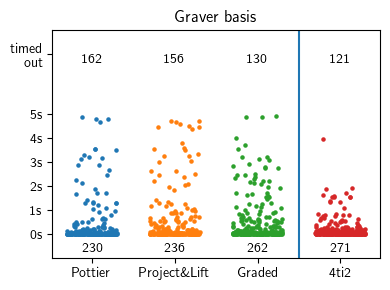

In [ ]:
# vecs = [np.array(new_list[c]) for c in col_names]
fig,axes = plt.subplots(1,1, figsize=(4, 3))
# fig,axes = plt.subplots(1,3, figsize=(12, 3), width_ratios=[4,3,2])
y_tout = 7
xx = (np.random.rand(len(data)) - 0.5) * 0.6
yy = np.random.rand(len(data)) + y_tout
for jj in [2]:#range(3):
    prefix = {0:('Hil', 'Hilbert basis'), 1:('Ray', 'Extremal rays'), 2:('Gra', 'Graver basis')}
    ax = axes
    jj_col_names = [c for c in col_names if c.startswith(prefix[jj][0])]
    jj_col_names = [(order_map[c.split('_')[1]], c) for c in jj_col_names]
    jj_col_names = [c for _,c in sorted(jj_col_names)]
    print(jj_col_names, sorted(jj_col_names))
    for i, col_name in enumerate(jj_col_names):
        vv = np.array(data[col_name])
        filter_tout = np.logical_not(np.isnan(vv))
        num_tout = np.sum(np.logical_not(filter_tout))
        # vv[vv<0] = yy[vv<0]
        ax.scatter(xx[filter_tout]+i, vv[filter_tout], s=5)
        ax.text(i, y_tout, f'{num_tout}', fontsize=10, ha='center', va='bottom')
        ax.text(i, -.75, f'{len(vv)-num_tout}', fontsize=10, ha='center')
    ax.set_title(prefix[jj][1])
    
    ax.set_xticks(range(len(jj_col_names)), [remap(c.split('_')[1]) for c in jj_col_names])
    ax.set_yticks(list(range(6))+[y_tout+.5], [f'{s}s' for s in list(range(6))]+['timed\nout'])
    ax.vlines(i-.5, -1, y_tout+2) 
    ax.set_ylim(-1, y_tout+1.5)
plt.tight_layout()
plt.savefig(f'{plot_list_name}-time.pdf', bbox_inches='tight')
plt.show()

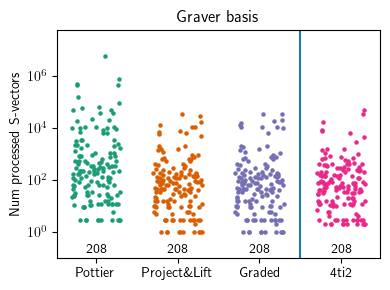

In [6]:
from matplotlib  import colormaps
cmap = colormaps['Dark2']
fig,axes = plt.subplots(1,1, figsize=(4, 3))
# fig,axes = plt.subplots(1,3, figsize=(12, 3), width_ratios=[4,3,2])
for jj in [2]: #range(3):
#     if jj==1: continue
    prefix = {0:('Hil', 'Hilbert basis'), 1:('Ray', 'Extremal rays'), 2:('Gra', 'Graver basis')}
    ax = axes
    jj_col_names = [c for c in col_names if c.startswith(prefix[jj][0])]# and not '4ti2' in c]
    jj_col_names = [(order_map[c.split('_')[1]], c) for c in jj_col_names]
    jj_col_names = [c for _,c in sorted(jj_col_names)]
    NL = data.copy()
    y_tout = 1
    for n in jj_col_names:
        # NL = NL[ NL[n+'_C'] != -1 ]
        NL = NL[ np.logical_not(np.isnan(NL[n+'_C'])) ]
    for n in jj_col_names:
        vmax = NL[n+'_C'].max()
        y_tout = max(y_tout, 1 if np.isnan(vmax) else vmax)
    y_tout *= 10
    xx = (np.random.rand(len(NL)) - 0.5) * 0.6
    yy = np.random.rand(len(NL)) + y_tout
    for i, col_name in enumerate(jj_col_names):
        vv = np.array(NL[col_name])
        vC = np.array(NL[col_name+'_C'], dtype=int)
        tout_mask = vv<0
        num_tout = np.sum(tout_mask)
#         y_tout = 1e+15
        vC[tout_mask] = yy[tout_mask]
        vC[vC < 0] = 1
        ax.scatter(xx+i, vC, s=5, color=cmap(i))
#         ax.text(i, y_tout-.75, f'{num_tout}', fontsize=12, ha='center')
        ax.text(i, 0.15, f'{len(vv)-num_tout}', fontsize=10, ha='center')
    ax.set_title(prefix[jj][1])
    
    ax.set_xticks(range(len(jj_col_names)), [remap(c.split('_')[1]) for c in jj_col_names])
#     ax.set_yticks(list(range(6))+[y_tout+.5], [f'{s}s' for s in list(range(6))]+['timed\nout'])
    ax.vlines(i-.5, -1, y_tout+2) 
    ax.set_ylim(0.099, y_tout) 
    ax.set_yscale('log')
    ax.set_ylabel('Num processed S-vectors')
plt.tight_layout()
plt.savefig(f'{plot_list_name}-svectors.pdf', bbox_inches='tight')
plt.show()

Gra_PnL 156   Gra_pottier 162
Gra_degree 130   Gra_pottier 162
Gra_degree 130   Gra_PnL 156
Gra_4ti2 121   Gra_pottier 162
Gra_4ti2 121   Gra_PnL 156
Gra_4ti2 121   Gra_degree 130


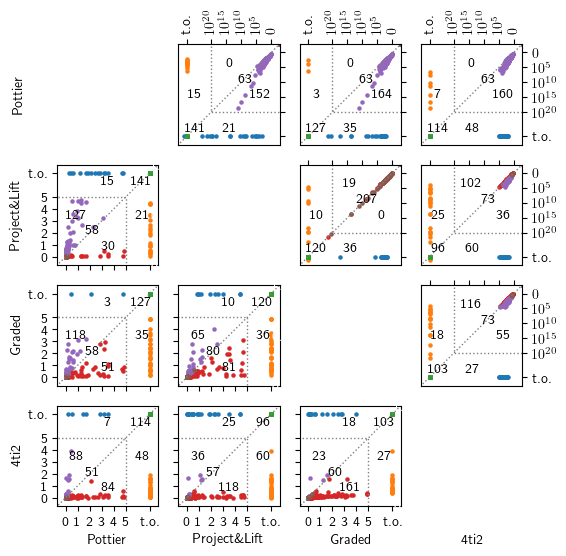

In [7]:
algos = ['Gra_pottier', 'Gra_PnL', 'Gra_degree', 'Gra_4ti2']
N = len(algos)
ticks, ticklabels, tout = [0,1,2,3,4,5,7], [0,1,2,3,4,5,'t.o.'], 7
# ticks_C, ticklabels_C, tout_C = [0,1,2,3,4,5,6,8], ['$0$', '', '$10^2$', '', '$10^4$', '', '$10^6$', 't.o.'], 8
ticks_C, ticklabels_C, tout_C = [0,5,10,15,20,28], ['$0$', '$10^5$', '$10^{10}$', '$10^{15}$', '$10^{20}$', 't.o.'], 28
fig,axes = plt.subplots(N,N, figsize=(1.5*N, 1.5*N))#, sharex=True, sharey=True)

for i in range(4):
    for j in range(4):
        if i > j:
            axes[i,j].set_xticks(ticks)
            axes[i,j].set_yticks(ticks)
            axes[i,j].set_xticklabels(ticklabels if i==N-1 else [])
            axes[i,j].set_yticklabels(ticklabels if j==0 else [])
        if i < j:
            axes[i,j].xaxis.set_ticks_position('top')
            axes[i,j].yaxis.set_ticks_position('right')
            axes[i,j].set_xticks(ticks_C)
            axes[i,j].set_yticks(ticks_C)
            axes[i,j].set_xticklabels(ticklabels_C if i==0 else [], rotation=90)
            axes[i,j].set_yticklabels(ticklabels_C if j==N-1 else [])
            axes[i,j].invert_xaxis()
            axes[i,j].invert_yaxis()

for i in range(4):
    axes[N-1,i].set_xlabel(remap(algos[i].split('_')[1]))
    axes[i, 0 ].set_ylabel(remap(algos[i].split('_')[1]))

    # axes[i,N-1].set_ylabel(remap(algos[i].split('_')[1]))
    # axes[i,N-1].yaxis.set_label_position("right")

for i in range(N):
    for j in range(N):
        ax = axes[i][j]
        if i==j:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            # Hide the ticks
            ax.tick_params(axis='x', colors='white')
            ax.tick_params(axis='y', colors='white')
        else:
            if i > j: # time
                y_tout = tout
                p1, p2 = y_tout/8, y_tout/2
                p3, p4 = ticks[-2], 0.9*y_tout
                delta = y_tout/10
                ax.set_xlim(-delta, y_tout+delta) ; ax.set_ylim(-delta, y_tout+delta)
                D = np.nan_to_num(data[[algos[i], algos[j]]].to_numpy(), nan=y_tout)
                print(algos[i], np.sum(D[:,0]==y_tout), ' ', algos[j], np.sum(D[:,1]==y_tout))
            else: # s-vector counts
                y_tout = tout_C
                p1, p2 = y_tout/8, y_tout/2
                p3, p4 = ticks_C[-2], 0.9*y_tout
                delta = y_tout/10
                ax.set_xlim(y_tout+delta, -delta) ; ax.set_ylim(y_tout+delta, -delta)
                # print(np.max(np.nan_to_num(np.log10(data[[algos[i]+'_C', algos[j]+'_C']].to_numpy()+0.001))))
                D = np.nan_to_num(np.log10(data[[algos[i]+'_C', algos[j]+'_C']].to_numpy()+0.001), nan=y_tout)

            D = D[:, [1,0]]

            f = (D[:,0] != y_tout) & (D[:,1] == y_tout)
            ax.scatter(D[f,0], D[f,1], s=5)
            ax.text(p2, p4, f'{np.sum(f)}', ha='center', va='center')

            f = (D[:,0] == y_tout) & (D[:,1] != y_tout)
            ax.scatter(D[f,0], D[f,1], s=5)
            ax.text(p4, p2, f'{np.sum(f)}', ha='center', va='center')

            f = (D[:,0] == y_tout) & (D[:,1] == y_tout)
            ax.scatter(D[f,0], D[f,1], s=5)
            ax.text(p4, p4, f'{np.sum(f)}', ha='center', va='center')

            # remove timeouts
            D = D[~(D[:,0] == y_tout) & ~(D[:,1] == y_tout)]

            f = (D[:,0] > D[:, 1]) & (D[:,1] < y_tout)
            ax.scatter(D[f,0], D[f,1], s=5)
            ax.text(p2, p1, f'{np.sum(f)}', ha='center', va='center')

            f = D[:,0] < D[:, 1]
            ax.scatter(D[f,0], D[f,1], s=5)
            ax.text(p1, p2, f'{np.sum(f)}', ha='center', va='center')

            f = D[:,0] == D[:, 1]
            ax.scatter(D[f,0], D[f,1], s=5)
            ax.text((p1+p2)/2, (p1+p2)/2, f'{np.sum(f)}', ha='center', va='center')

            ax.plot([-10,100], [-10,100], ls=':', lw=1, c='grey')
            ax.plot([-10,p3,p3], [p3,p3,-10], ls=':', lw=1, c='grey')
            
plt.savefig(f'{plot_list_name}-comparative.pdf', bbox_inches='tight')
plt.show()

In [7]:
data.head(5)

,model,mdd_nodes,mdd_edges,4ti2_completes,4ti2_builds,4ti2_reductions,4ti2_insertions,4ti2_completed_svectors,out_sz,Gra_4ti2,Gra_4ti2_C,num_Zgens,num_vars,Gra_pottier,Gra_pottier_C,Gra_PnL,Gra_PnL_C,Gra_degree,Gra_degree_C
0,AirplaneLD-COL-0010,274.0,311.0,172.0,1262.0,0.0,3.0,3.0,38.0,0.02,3.0,35,89,0.01,12.0,0.03,3.0,0.04,3.0
1,AirplaneLD-COL-0020,479.0,546.0,262.0,4261.0,0.0,3.0,3.0,68.0,0.07,3.0,65,159,0.02,11.0,0.09,3.0,0.11,3.0
2,AirplaneLD-COL-0050,1094.0,1251.0,532.0,24061.0,0.0,3.0,3.0,158.0,0.53,3.0,155,369,0.19,11.0,0.62,3.0,0.62,3.0
3,AirplaneLD-PT-0010,188.0,224.0,171.0,1265.0,0.0,3.0,3.0,38.0,0.02,3.0,35,89,0.01,12.0,0.03,3.0,0.03,3.0
4,AirplaneLD-PT-0020,401.0,467.0,261.0,4265.0,0.0,3.0,3.0,68.0,0.06,3.0,65,159,0.02,12.0,0.09,3.0,0.10,3.0


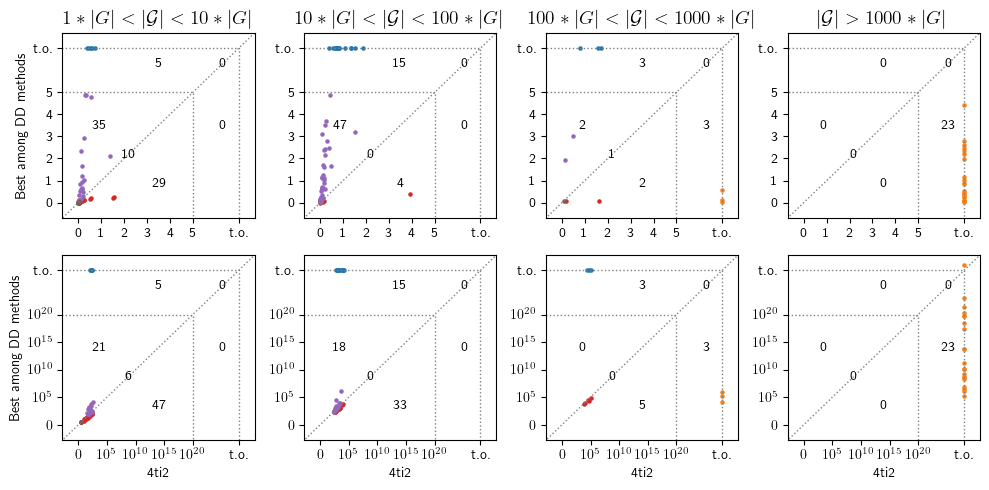

In [48]:
def partition_datapoints(ax, vX, vY, tout):
    p1, p2 = tout/8, tout/2
    p3, p4 = ax.get_xticks()[-2], 0.9*tout

    f = (vX != tout) & (vY == tout)
    ax.scatter(vX[f], vY[f], s=5)
    ax.text(p2, p4, f'{np.sum(f)}', ha='center', va='center')

    f = (vX == tout) & (vY != tout)
    ax.scatter(vX[f], vY[f], s=5)
    ax.text(p4, p2, f'{np.sum(f)}', ha='center', va='center')

    f = (vX == tout) & (vY == tout)
    ax.scatter(vX[f], vY[f], s=5)
    ax.text(p4, p4, f'{np.sum(f)}', ha='center', va='center')

    # remove timeouts
    fNT = ~(vX == tout) & ~(vY == tout)

    f = (vX > vY) & (vY < tout) & fNT
    ax.scatter(vX[f], vY[f], s=5)
    ax.text(p2, p1, f'{np.sum(f)}', ha='center', va='center')

    f = (vX < vY) & fNT
    ax.scatter(vX[f], vY[f], s=5)
    ax.text(p1, p2, f'{np.sum(f)}', ha='center', va='center')

    f = (vX == vY) & fNT
    ax.scatter(vX[f], vY[f], s=5)
    ax.text((p1+p2)/2, (p1+p2)/2, f'{np.sum(f)}', ha='center', va='center')

    ax.plot([-10,100], [-10,100], ls=':', lw=1, c='grey')
    ax.plot([-10,p3,p3], [p3,p3,-10], ls=':', lw=1, c='grey')
    ax.plot([-10,tout,tout], [tout,tout,-10], ls=':', lw=1, c='grey')

def mkplot_time(ax, vX, vY, tX=None, tY=None):
    vX, vY = np.array(vX), np.array(vY)
    ticks, ticklabels, tout = [0,1,2,3,4,5,7], [0,1,2,3,4,5,'t.o.'], 7
    ax.set_xticks(ticks) ; ax.set_xticklabels(ticklabels)
    ax.set_yticks(ticks) ; ax.set_yticklabels(ticklabels)
    if tX is not None: ax.set_xlabel(remap(tX))
    if tY is not None: ax.set_ylabel(remap(tY))

    delta = tout/10
    ax.set_xlim(-delta, tout+delta) ; ax.set_ylim(-delta, tout+delta)
    vX = np.nan_to_num(vX, nan=tout)
    vY = np.nan_to_num(vY, nan=tout)

    partition_datapoints(ax, vX, vY, tout)

def mkplot_svectors(ax, vX, vY, tX=None, tY=None):
    vX, vY = np.array(vX), np.array(vY)
    ticks, ticklabels, tout = [0,5,10,15,20,28], ['$0$', '$10^5$', '$10^{10}$', '$10^{15}$', '$10^{20}$', 't.o.'], 28
    ax.set_xticks(ticks) ; ax.set_xticklabels(ticklabels)
    ax.set_yticks(ticks) ; ax.set_yticklabels(ticklabels)
    if tX is not None: ax.set_xlabel(remap(tX))
    if tY is not None: ax.set_ylabel(remap(tY))

    delta = tout/10
    ax.set_xlim(-delta, tout+delta) ; ax.set_ylim(-delta, tout+delta)
    vX = np.nan_to_num(np.log10(vX), nan=tout)
    vY = np.nan_to_num(np.log10(vY), nan=tout)

    partition_datapoints(ax, vX, vY, tout)

# fig, axes = plt.subplots(1, 2, squeeze=False, figsize=(8,4))
# vX, vY = data['Gra_4ti2'], data['Gra_pottier']
# mkplot_time(axes[0,0], vX, vY)
# vX, vY = data['Gra_4ti2_C'], data['Gra_pottier_C']
# mkplot_svectors(axes[0,1], vX, vY)
# plt.show()

mX, mY = '4ti2', 'Best'
fig, axes = plt.subplots(2, 4, squeeze=False, figsize=(10,5))
ratios = [1,10,100,1000]
for i,mul in enumerate(ratios):
    D = data.copy()
    # D[D.isna()] = np.inf
    # D['Gra_ALL'] = np.minimum(D['Gra_degree'], D['Gra_pottier'], D['Gra_PnL'])
    # D[D.isinf()] = np.nan
    # print(D.head(10))
    D.fillna(np.inf, inplace=True)
    D['Gra_Best'] = np.minimum(D['Gra_degree'], np.minimum(D['Gra_pottier'], D['Gra_PnL']))
    D['Gra_Best_C'] = np.minimum(D['Gra_degree_C'], np.minimum(D['Gra_pottier_C'], D['Gra_PnL_C']))
    D.replace([np.inf, -np.inf], np.nan, inplace=True)

    # a = np.nan_to_num(D['Gra_degree'], nan=np.inf)
    # b = np.nan_to_num(D['Gra_pottier'], nan=np.inf)
    # c = np.nan_to_num(D['Gra_PnL'], nan=np.inf)
    # minABC = np.minimum(a,b,c)
    # # if i==0: print(minABC)
    # minABC[np.isinf(minABC)] = np.nan
    # # if i==0: print(minABC)
    # D['Gra_ALL'] = minABC

    D = D[D.num_Zgens >= 10]
    D = D[~D.out_sz.isna()]
    assert not D.out_sz.isna().any()
    if i==len(ratios)-1:
        # display(D[ D.Gra_ALL.isna() & D.Gra_4ti2.isna() ])
        title = f'$|\\mathcal{{G}}| > {ratios[i]}*|G|$'
        D = D[(ratios[i]*D.num_Zgens < D.out_sz)]
    else:
        title = f'${ratios[i]}*|G|< |\\mathcal{{G}}| < {ratios[i+1]}*|G|$'
        D = D[(ratios[i]*D.num_Zgens < D.out_sz) & (D.out_sz < ratios[i+1]*D.num_Zgens)]
    # if i==0: display(D[ D.Gra_ALL.isna() & D.Gra_4ti2.isna() ])
    vX, vY = D[f'Gra_{mX}'], D[f'Gra_{mY}']
    mkplot_time(axes[0,i], vX, vY, tX='', tY=mY if i==0 else '')
    vX, vY = D[f'Gra_{mX}_C'], D[f'Gra_{mY}_C']
    mkplot_svectors(axes[1,i], vX, vY, tX=mX, tY=mY if i==0 else '')
    axes[0,i].set_title(title, fontsize=14)
plt.tight_layout()
plt.savefig(f'{plot_list_name}-stratified.pdf', bbox_inches='tight')
plt.show()

In [51]:
# np.minimum([0, 2, 5], 
#            [9, np.nan, np.inf])
D = data.copy()
D.fillna(np.inf, inplace=True)
# D[D.isna()] = np.inf
D['Gra_ALL'] = np.minimum(D['Gra_degree'], D['Gra_pottier'], D['Gra_PnL'])
D.replace([np.inf, -np.inf], np.nan, inplace=True)
# D[D.isinf()] = np.nan
display(D.head(10))


/var/folders/b7/q14x28gx41l_jc7rpy5q038r0000gn/T/ipykernel_40188/2098248390.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D['Gra_ALL'] = np.minimum(D['Gra_degree'], D['Gra_pottier'], D['Gra_PnL'])


,model,mdd_nodes,mdd_edges,4ti2_completes,4ti2_builds,4ti2_reductions,4ti2_insertions,4ti2_completed_svectors,out_sz,Gra_4ti2,Gra_4ti2_C,num_Zgens,num_vars,Gra_pottier,Gra_pottier_C,Gra_PnL,Gra_PnL_C,Gra_degree,Gra_degree_C,Gra_ALL
0,AirplaneLD-COL-0010,274.0,311.0,172.0,1262.0,0.0,3.0,3.0,38.0,0.02,3.0,35,89,0.01,12.0,0.01,3.0,0.04,3.0,0.01
1,AirplaneLD-COL-0020,479.0,546.0,262.0,4261.0,0.0,3.0,3.0,68.0,0.07,3.0,65,159,0.02,11.0,0.02,3.0,0.11,3.0,0.02
2,AirplaneLD-COL-0050,1094.0,1251.0,532.0,24061.0,0.0,3.0,3.0,158.0,0.53,3.0,155,369,0.19,11.0,0.19,3.0,0.62,3.0,0.19
3,AirplaneLD-PT-0010,188.0,224.0,171.0,1265.0,0.0,3.0,3.0,38.0,0.02,3.0,35,89,0.01,12.0,0.01,3.0,0.03,3.0,0.01
4,AirplaneLD-PT-0020,401.0,467.0,261.0,4265.0,0.0,3.0,3.0,68.0,0.06,3.0,65,159,0.02,12.0,0.02,3.0,0.10,3.0,0.02
5,AirplaneLD-PT-0050,724.0,880.0,531.0,24065.0,0.0,3.0,3.0,158.0,0.52,3.0,155,369,0.17,12.0,0.17,3.0,0.60,3.0,0.17
6,Angiogenesis-PT-01,1891.0,2039.0,14194.0,1999969.0,5764.0,1721.0,7485.0,1729.0,0.21,7485.0,8,39,3.55,490834.0,0.96,7209.0,0.96,12854.0,0.96
7,Angiogenesis-PT-10,1386.0,1529.0,10401.0,1132213.0,6908.0,1721.0,8629.0,1729.0,0.15,8629.0,8,39,4.78,483996.0,0.56,6241.0,0.56,10793.0,0.56
8,AutoFlight-PT-01a,1482.0,1698.0,748.0,12314.0,178.0,261.0,439.0,271.0,0.00,439.0,10,32,0.24,20847.0,0.10,563.0,0.10,796.0,0.10
9,AutoFlight-PT-01b,20063.0,20387.0,21565.0,132498.0,494.0,315.0,809.0,325.0,0.08,809.0,10,114,NaN,NaN,3.09,NaN,3.09,1916.0,3.09


In [8]:
D = data[['Gra_pottier', 'Gra_4ti2']]
D = D.dropna()
# display(D)

print(np.sum(D.Gra_pottier > D.Gra_4ti2))
print(np.sum(D.Gra_pottier < D.Gra_4ti2))


84
88


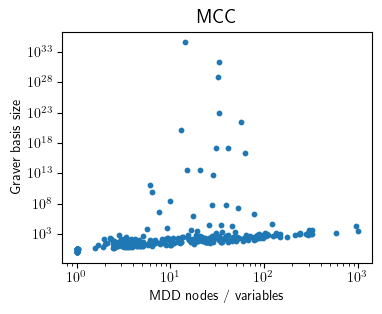

In [6]:
plt.figure(figsize=(4,3))
plt.scatter(data.mdd_nodes / data.num_vars, data.out_sz, s=10)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Graver basis size')
plt.xlabel('MDD nodes / variables')
plt.title('MCC' if plot_list_name=='models_mcc2' else 'rand', size=14)
plt.savefig(f'{plot_list_name}-mddsizes.pdf', bbox_inches='tight')
plt.show()

In [35]:
# plt.scatter(data.mdd_nodes, data.out_sz)
# plt.yscale('log')
# plt.xscale('log')
# plt.ylabel('Graver basis size')
# plt.xlabel('MDD nodes')
# # plt.plot([10,10000], [10,10000], lw=1, c='r')

# Old code

In [ ]:
kA, kB = 'Hil_nL', 'Hil_nLH'
kAC, kBC = kA+'_C', kB+'_C'
print(f'{kB} better than {kA}:')
pd.options.display.float_format = '{:,.0f}'.format
data2 = data[(data[kAC]>=0) | (data[kBC]>=0)].copy()
data2[kAC] = data2[kAC].replace(-1, 1000000)
data2[kBC] = data2[kBC].replace(-1, 1000000)
data2[ data2[kAC] > 2*data2[kBC] + 1 ][['model', kA, kAC, kB, kBC]]

In [ ]:
print('HNF better than IGE:')
data2[ data2.Hil_IGE_C > 2*data2.Hil_HNF_C + 1 ][['model', 'Hil_HNF', 'Hil_HNF_C', 'Hil_IGE', 'Hil_IGE_C']]

In [ ]:
def make_3dplot(ax):
    ax.plot([0,2.5], [0,7.5], [0,0])
    ax.plot([0,2.5], [0,0], [0,7.5])

    ax.plot_trisurf(np.array([0, 2.5, 2.5]), 
                    np.array([0, 7.5, 0]),
                    np.array([0, 0, 7.5]), alpha=.25)
    ax.scatter3D([0], [0], [0], c='black')
    ax.scatter3D([1], [3], [0], c='r')
    ax.scatter3D([1], [0], [3], c='r')
    ax.scatter3D([1], [1], [2], c='g')
    ax.scatter3D([1], [2], [1], c='g')

    ax.scatter3D([2], [2], [4], c='b')
    ax.scatter3D([2], [4], [2], c='b')
    ax.scatter3D([2], [1], [5], c='b')
    ax.scatter3D([2], [5], [1], c='b')
    ax.scatter3D([2], [6], [0], c='b')
    ax.scatter3D([2], [0], [6], c='b')
    ax.scatter3D([2], [3], [3], c='b')

    ax.set_xlabel('$P_0$', fontsize=14)
    ax.set_ylabel('$P_1$', fontsize=14)
    ax.set_zlabel('$P_2$', fontsize=14)

    ax.set_xticks(range(3))
    ax.set_yticks(range(7))
    ax.set_zticks(range(7))

ax = plt.figure().add_subplot(projection='3d')
make_3dplot(ax)

In [ ]:
# Rotate the axes and update
for angle in tqdm(range(0, 360*4 + 1)):
    ax = plt.figure().add_subplot(projection='3d')
    # Normalize the angle to the range [-180, 180] for display
    angle_norm = (angle + 180) % 360 - 180

    # Cycle through a full rotation of elevation, then azimuth, roll, and all
    elev = azim = roll = 0
    if angle <= 360:
        elev = angle_norm
    elif angle <= 360*2:
        azim = angle_norm
    elif angle <= 360*3:
        roll = angle_norm
    else:
        elev = azim = roll = angle_norm

    # Update the axis view and title
    ax.view_init(elev, azim, roll)
    plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))
    make_3dplot(ax)

    # plt.draw()
    plt.savefig(f"video/image_{angle:03}.png")
    plt.close()
    # plt.pause(.001)

    # ffmpeg -framerate 24 -i video/image_%3d.png -r 10 -pix_fmt yuv420p video.mp4

In [ ]:
swaps = [(3, 0), (6, 1), (11, 2), (12, 3), (13, 4), (14, 5), (16, 6), (17, 7), (18, 8), (19, 9), 
         (20, 10), (21, 11), (22, 12), (23, 13), (24, 14), (16, 15), (22, 16), (18, 17), (20, 18), 
         (23, 19), (24, 20), (24, 21), (24, 22), (23, 23), (24, 24)]
l = list(range(25))
for a,b in swaps:
    l[a], l[b] = l[b], l[a]
print(l)

# Problem shuffle

In [506]:
with open('mats_basic/55.mat', 'r') as f:
    nr, nc = [int(x) for x in f.readline().split()]
    A = np.zeros([nr, nc], dtype=int)
    for i in range(nr):
        data = [int(x) for x in f.readline().split()]
        for j in range(nc):
            A[i,j] = data[j]
# print(nr, nc)
# print(A)

#randomly shuffle columns of A
for k in range(100):
    j1 = np.random.randint(nc)
    j2 = np.random.randint(nc)
    c1 = A[:,j1].copy()
    c2 = A[:,j2].copy()
    A[:,j1] = c2 ; A[:,j2] = c1
# print(A)

with open('mats_basic/55shuffled.mat', 'w') as f:
    print(nr,nc, file=f)
    for i in range(nr):
        for j in range(nc):
            print(A[i,j], end=' ', file=f)
        print('', file=f)


In [8]:
# x = np.array(list(range(15)))
# y2 = x + 10
# y3 = 2*x

# plt.plot(x, y2, c='#4472c4')
# plt.plot(x, y3, c='#c55a11')
# plt.savefig(f"deadlock.png", dpi=300)